<a href="https://colab.research.google.com/github/Keerys/MVP---Machine-Learning/blob/main/MVP_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Definição do problema

O Modelo tem com objetivo prever a partir do dataset se o cliente está apto ou não a receber o empréstimo, de acordo com os dados fornecidos, sendo um problema de Classificação.

O Dataset é composto pelos seguintes atributos:
1. loan_id
2. no_of_dependents (Number of Dependents of the Applicant)
3. education (Education of the Applicant)
4. self_employed (Employment Status of the Applicant)
5. income_annum (Annual Income of the Applicant)
6. loan_amount
7. loan_term (Loan Term in Years)
8. cibil_score (Credit Score)
9. residential_assets_value
10. commercial_assets_value
11. luxury_assets_value
12. bank_asset_value
13. loan_status (Loan Approval Status)

A proporção do status do empréstimo é:

approved: 62%    
rejected: 38%


Para o meu entendimento, para uma previsão correta, não são necessários os atributos 'loan_id', 'education' e 'self_employed', uma vez que eles não apresentam uma relação importante para o target, como os outros atributos como 'loan_amount' e 'income_annum' apresentam.

Tenho como premissa que apesar de vários atributos, os que possuem mais peso para a decisão são 'loan_amount', 'income_annum' e 'cibil_score'.


# 2.Preparação dos dados




## 2.1 Imports

In [193]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.feature_selection import f_classif # para o teste ANOVA da Seleção Univariada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE # para a Eliminação Recursiva de Atributos
from sklearn.feature_selection import SelectKBest # para a Seleção Univariada
from sklearn.ensemble import ExtraTreesClassifier #Importancia de atributos extra tree

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

## 2.2 Carga do Dataset

Ao fazer a análise do Dataset, nota-se que ele está desbalanceado. Fiz o balanceamento manualmente removendo o excedende de linhas com o status 'approved', deixando igual, com 50% approved e 50% rejected.

(obs: o Dataset original se encontra no repositório do Github.)

In [194]:
url = 'https://raw.githubusercontent.com/Keerys/MVP---Machine-Learning/main/loan_approval_dataset%20-%20Balanceado.csv'

dataset = pd.read_csv(url)


dataset.head()



,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
1,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
2,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
3,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
4,6,0,Graduate,Yes,4800000,13500000,10,319,6800000,8300000,13700000,5100000,Rejected


## 2.3 Separação em conjunto de teste e treino

Ao fazer a separação, já foi excluido os atributos que não considero necessários para o problema ('loan_id', 'education' e 'self_employed').

In [196]:
# Preparação dos dados

test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em bases de treino e teste (holdout)
atributos = [' no_of_dependents',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value',]

X = dataset[atributos].values # atributos
y = dataset[' loan_status'].values # classe (target)


X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## 2.4 Seleção de atributos


Para a seleção de atributos testei com a Eliminação Recursiva de Atributos, Importância de Atributos com ExtraTrees e SelectKBest, sendo o SelectKBest o que apresentou o melhor resultado.

Um ponto curioso é que foram selecionados 2 atributos diferentes da minha premissa: ' loan_term' e ' commercial_assets_value', Sendo o 'commercial_assets_value' uma grande surpresa ser selecionado ao invés de por exemplo 'income_annum'.


In [197]:
# SelectKBest ()

# Seleção de atributos com SelectKBest
best_var = SelectKBest(score_func=f_classif, k=4)

# Executa a função de pontuação em (X, y) e obtém os atributos selecionados
fit = best_var.fit(X, y)

# Reduz X para os atributos selecionados
features = fit.transform(X)

# Resultados
print('\nNúmero original de atributos:', X.shape[1])
print('\nNúmero reduzido de atributos:', features.shape[1])

# Exibe os atributos orginais
print("\nAtributos Originais:", atributos)

# Exibe as pontuações de cada atributos e os 4 escolhidas (com as pontuações mais altas)
np.set_printoptions(precision=3) # 3 casas decimais
print("\nScores dos Atributos Originais:", fit.scores_)
print("\nAtributos Selecionados:", best_var.get_feature_names_out(input_features=atributos))


Número original de atributos: 9

Número reduzido de atributos: 4

Atributos Originais: [' no_of_dependents', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value']

Scores dos Atributos Originais: [3.468e-01 1.869e-01 1.557e+00 3.538e+01 5.517e+03 9.256e-02 1.553e+00
 6.158e-01 7.789e-03]

Atributos Selecionados: [' loan_amount' ' loan_term' ' cibil_score' ' commercial_assets_value']


## 2.5 Criação do novo dataframe com os atributos selecionados

Nessa etapa transformei o X_train e o X_test em dataframe, e depois selecionei os atributos desejados

In [198]:
#Novo dataframe com os atributos selecionados
atributos_selecionados = [' loan_amount', ' loan_term', ' cibil_score', ' commercial_assets_value']


X2_train = pd.DataFrame(X_train, columns=atributos)
X2_test = pd.DataFrame(X_test, columns=atributos)

X2_train = X2_train[atributos_selecionados]
X2_test = X2_test[atributos_selecionados]


# 3.Modelagem e Treinamento

## 3.1 Criação e Avaliação do Modelo: linha base


Treinamento do modelo aplicaçando algoritmos normalmente usados em problemas de classificação, com os atributos já selecionados no Dataframe.

LR: 0.530233 (0.038284)
KNN: 0.506977 (0.027615)
CART: 0.954651 (0.014299)
NB: 0.892248 (0.014167)
SVM: 0.523643 (0.033408)
Bagging: 0.963566 (0.011909)
RF: 0.965116 (0.013538)
ET: 0.959690 (0.013449)
Ada: 0.963178 (0.013455)
GB: 0.968992 (0.012134)
Voting: 0.662403 (0.042792)


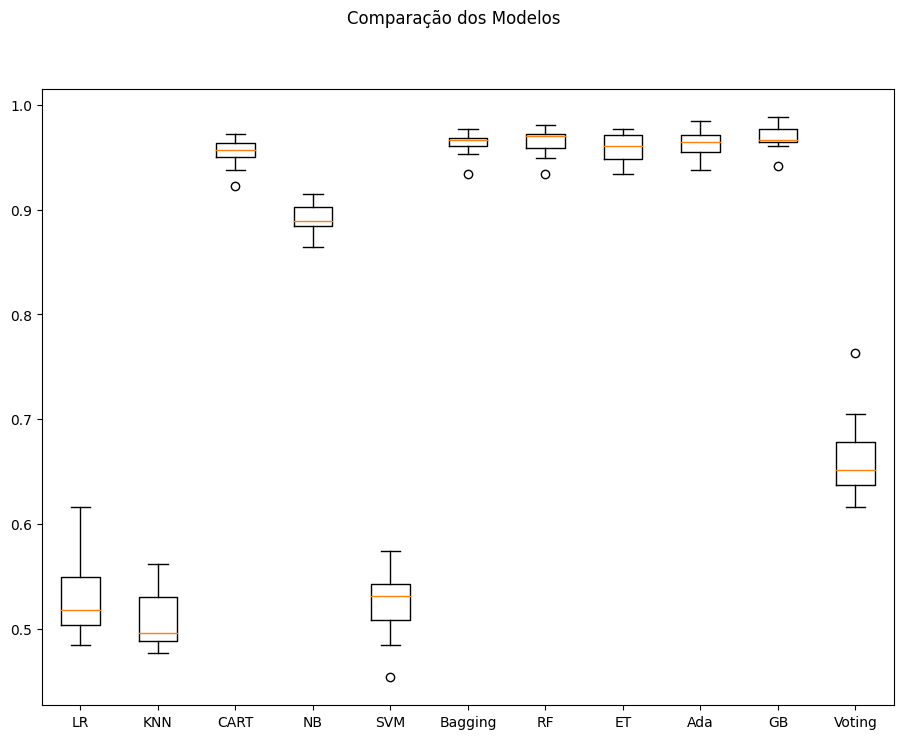

In [185]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))
model4 = LogisticRegression()
bases.append(('LR', model4))
model5 = KNeighborsClassifier()
bases.append(('KNN', model5))



# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X2_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
plt.rcParams.update({'font.size': 10}) # add depois
fig = plt.figure(figsize=(11,8))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## 3.2 Criação e Avaliação do Modelo: Padronizado e Normalizado



Treinamento do modelo aplicaçando algoritmos normalmente usados em problemas de classificação, com os atributos já selecionados, mas agora no Dataframe com dados Padronizados e Normalizados.

Os dados originais foram mantidos no código para facilitar a comparação entre todos os modelos. (original, padronizado e normalizado).

LR-orig: 0.530 (0.038)
KNN-orig: 0.507 (0.028)
CART-orig: 0.955 (0.014)
NB-orig: 0.892 (0.014)
SVM-orig: 0.524 (0.033)
Bag-orig: 0.964 (0.012)
RF-orig: 0.965 (0.014)
ET-orig: 0.960 (0.013)
Ada-orig: 0.963 (0.013)
GB-orig: 0.969 (0.012)
Vot-orig: 0.662 (0.043)
LR-padr: 0.928 (0.013)
KNN-padr: 0.931 (0.012)
CART-padr: 0.957 (0.015)
NB-padr: 0.950 (0.010)
SVM-padr: 0.944 (0.015)
Bag-padr: 0.964 (0.015)
RF-padr: 0.965 (0.013)
ET-padr: 0.961 (0.014)
Ada-padr: 0.963 (0.013)
GB-padr: 0.969 (0.012)
Vot-padr: 0.946 (0.014)
LR-norm: 0.928 (0.015)
KNN-norm: 0.931 (0.016)
CART-norm: 0.957 (0.015)
NB-norm: 0.950 (0.010)
SVM-norm: 0.946 (0.014)
Bag-norm: 0.964 (0.014)
RF-norm: 0.963 (0.014)
ET-norm: 0.960 (0.014)
Ada-norm: 0.963 (0.013)
GB-norm: 0.969 (0.012)
Vot-norm: 0.948 (0.014)


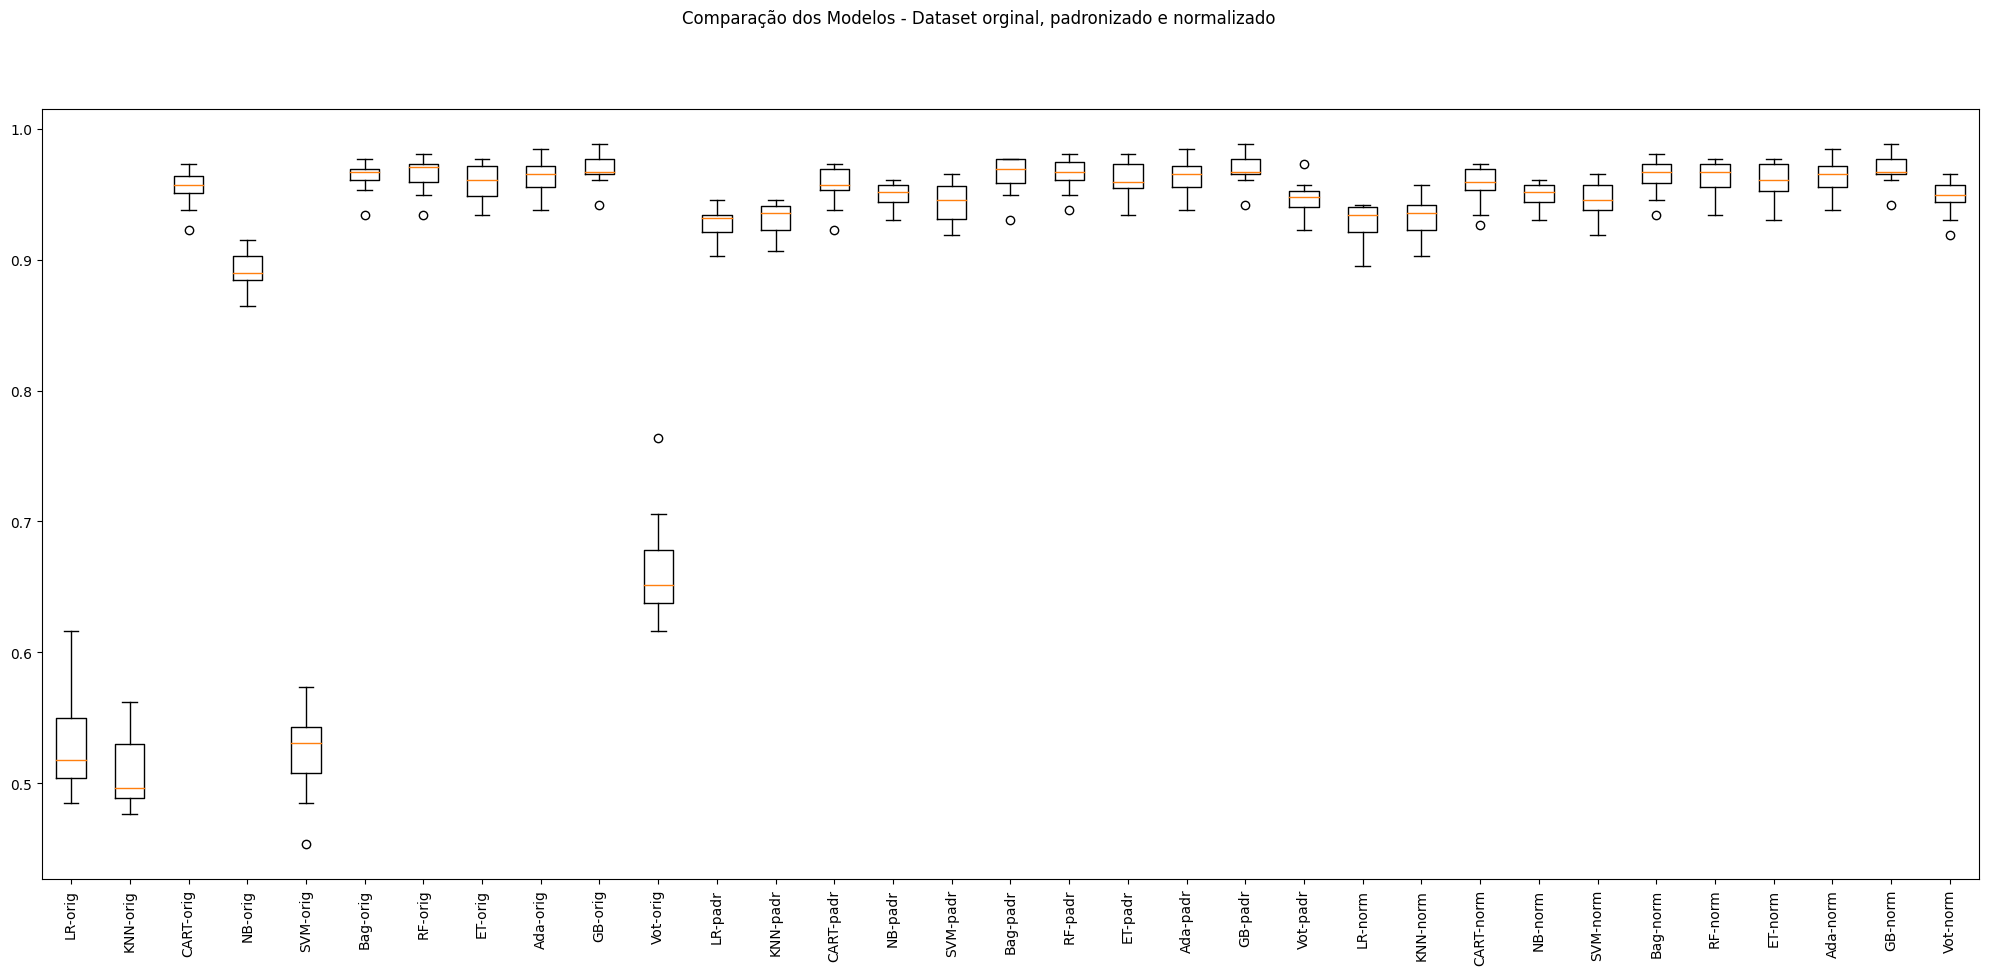

In [186]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X2_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,10))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## 3.3 Otimização dos Hiperparâmetros

Nesse caso testei a otimização do RF, onde obteve um melhor resultado com o RF em cima dos dados patronizados. Selecionei esses parâmetros pois ao tentar com todos, o tempo de execução estava muito grande, então selecionei os que eu achei mais relevantes.

In [187]:
# Tuning do RF

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))


param_grid = {
    'RF__n_estimators': [10, 50, 100],
    'RF__max_features': ['auto', 'sqrt', 'log2'],
    'RF__max_depth': [10, 20, 30],
    'RF__criterion': ["gini", "entropy"]
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X2_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: RF-orig - Melhor: 0.966667 usando {'RF__criterion': 'gini', 'RF__max_depth': 10, 'RF__max_features': 'auto', 'RF__n_estimators': 50}
Sem tratamento de missings: RF-padr - Melhor: 0.965504 usando {'RF__criterion': 'gini', 'RF__max_depth': 10, 'RF__max_features': 'sqrt', 'RF__n_estimators': 50}
Sem tratamento de missings: RF-norm - Melhor: 0.966667 usando {'RF__criterion': 'gini', 'RF__max_depth': 10, 'RF__max_features': 'sqrt', 'RF__n_estimators': 10}


# 4.AVALIAÇÃO DO RESULTADO - Finalização do Modelo


## 4.1 Avaliação do Modelo com o conjunto de teste

Avaliei o modelo usando a otimização dos hipermarâmetros. O melhor resultado foi obtido com os dados originais.

In [199]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X2_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X2_train) # aplicação da padronização no conjunto de treino
model = RandomForestClassifier(criterion= 'gini', max_depth= 10, max_features= 'auto', n_estimators= 50)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X2_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.9535603715170279


Como o resultado não ficou muito diferente do treinamento, posso observar que não houve overfitting no modelo.

## 4.2 Preparando o modelo com todo o dataset

In [200]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

RandomForestClassifier(max_depth=10, max_features='auto', n_estimators=50)

## 4.3 Conclusão

Analisando os testes de modelos e seu funcionamento, pude perceber que o melhor modelo para ser utilizado nesse problema é o RandomForest, com os dados padronizados, e com os hiperparâmetros otimizados.

É possível concluir que os dados mais importantes e necessários para avaliar se o cliente está apto ou nao para o empréstimo são: ' loan_amount', ' loan_term', ' cibil_score', ' commercial_assets_value'.

Foram incluídos 2 novos dados além dos que estavam na premissa do problema. com ' commercial_assets_value' sendo um atributo inesperado de ser usado, porém vimos que também é essencial para resolver o problema